# **Predict Future Mid-Price Movement: SPY Stock Index (Historical Daily Returns)**

This project implements classical machine learning baselines to predict short-term price movements of the SPY stock index using historical daily returns. It demonstrates two approaches:

(1) a classical autoencoder (AE) combined with a multi-layer perceptron (MLP), which compresses recent return patterns into a low-dimensional latent space before predicting the next-day movement.

(2) a principal component analysis (PCA) followed by a support vector machine (SVM) as a fast linear benchmark.

The notebook carefully applies chronological train-test splits to prevent lookahead bias, scales features using training data only, and evaluates models with multiple metrics including accuracy, precision, recall, and F1 score.

Finally, it includes a small backtest simulation to visualise how a simple trading strategy based on model predictions would perform over time, providing a practical connection between predictive modeling and financial decision-making.

It addresses:
- Chronological split (no future leakage)
- Correct indexing for rolling windows
- Scaling features and training AE/PCA only on train data
- Multiple metrics reporting (accuracy, precision, recall, F1)
- A small backtest for trading strategy simulation

**Install required packages**

In [17]:
# Install required packages
!pip install yfinance scikit-learn tensorflow matplotlib seaborn

**STEP 1: Import libraries**

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

**STEP 2: Download and prepare financial data**

In [19]:
symbol = "SPY"
data = yf.download(symbol, start="2018-01-01", end="2023-01-01", progress=False)

# Use Adjusted Close if available
price_col = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
data['Return'] = data[price_col].pct_change()
data.dropna(inplace=True)

# Create features and labels using rolling window of past N days
N = 10
X, y = [], []
for i in range(N, len(data)-1):
    X.append(data['Return'].values[i-N:i])
    y.append(1 if data['Return'].values[i+1] > 0 else 0)

X = np.array(X)
y = np.array(y)
print("Features shape:", X.shape)
print("Labels shape:", y.shape)

# Preview sample
sample_df = pd.DataFrame(X[:5], columns=[f"Return_t-{i}" for i in range(N, 0, -1)])
sample_df["Next_Move"] = y[:5]
print("Sample of model-ready data (first 5 rows):")
display(sample_df)

/tmp/ipython-input-1979770381.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start="2018-01-01", end="2023-01-01", progress=False)


Features shape: (1247, 10)
Labels shape: (1247,)
Sample of model-ready data (first 5 rows):


,Return_t-10,Return_t-9,Return_t-8,Return_t-7,Return_t-6,Return_t-5,Return_t-4,Return_t-3,Return_t-2,Return_t-1,Next_Move
0,0.006325,0.004214,0.006665,0.001828,0.002264,-0.001530,0.007296,0.006519,-0.003419,0.009532,1
1,0.004214,0.006665,0.001828,0.002264,-0.001530,0.007296,0.006519,-0.003419,0.009532,-0.001680,1
2,0.006665,0.001828,0.002264,-0.001530,0.007296,0.006519,-0.003419,0.009532,-0.001680,0.004549,1
3,0.001828,0.002264,-0.001530,0.007296,0.006519,-0.003419,0.009532,-0.001680,0.004549,0.008131,0
4,0.002264,-0.001530,0.007296,0.006519,-0.003419,0.009532,-0.001680,0.004549,0.008131,0.002122,1


**STEP 2B: Visualise financial data and label distribution**

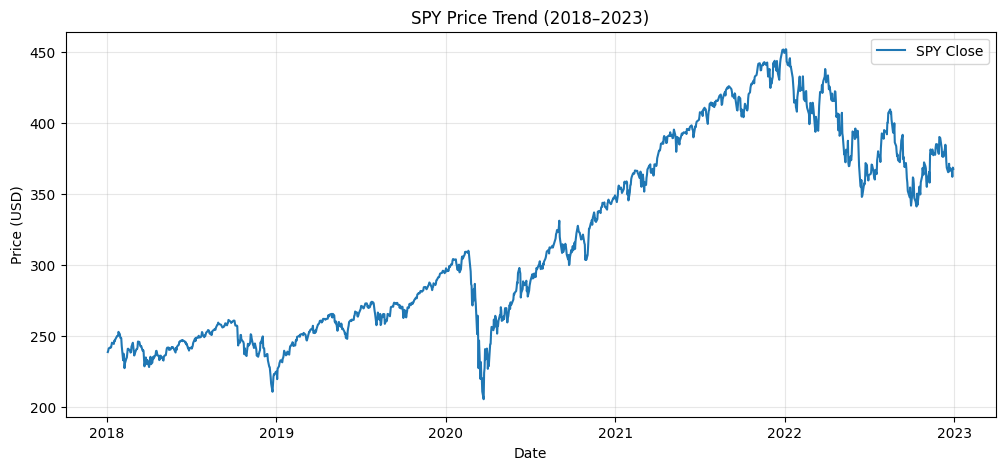

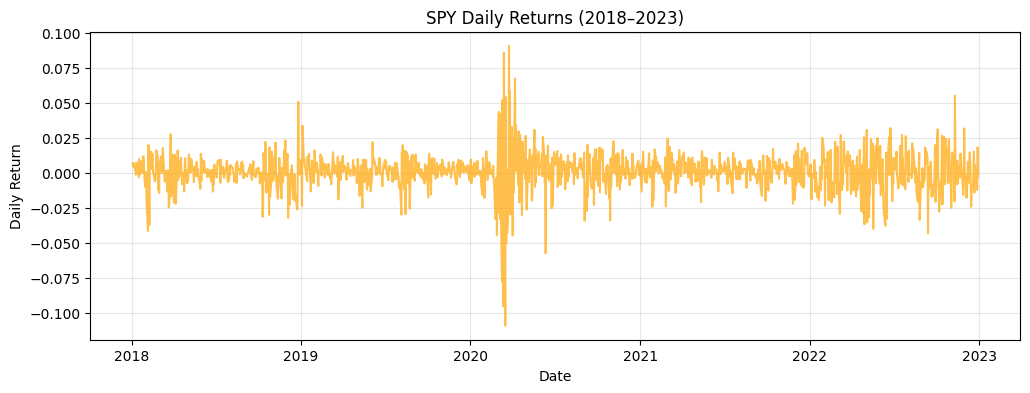

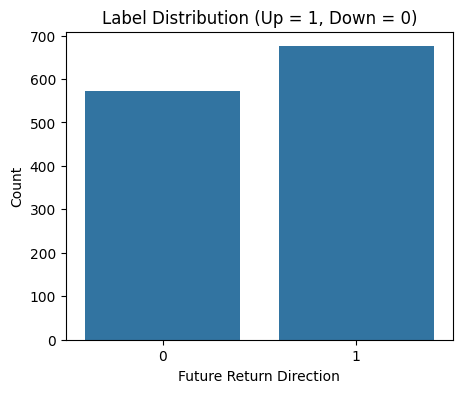

Total samples: 1247 | Ups: 675 | Downs: 572


In [20]:
plt.figure(figsize=(12, 5))
plt.plot(data.index, data[price_col], label=f"{symbol} {price_col}")
plt.title(f"{symbol} Price Trend (2018–2023)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(data.index, data['Return'], color='orange', alpha=0.7)
plt.title(f"{symbol} Daily Returns (2018–2023)")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(5, 4))
sns.countplot(x=y)
plt.title("Label Distribution (Up = 1, Down = 0)")
plt.xlabel("Future Return Direction")
plt.ylabel("Count")
plt.show()

print(f"Total samples: {len(y)} | Ups: {np.sum(y)} | Downs: {len(y)-np.sum(y)}")

**STEP 3: Chronological train-test split**

In [21]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Scale features based on training set only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**STEP 4: Classical Autoencoder (AE)**

In [22]:
input_dim = X_train_scaled.shape[1]
encoding_dim = 4

# Build Autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Train AE
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=20, batch_size=16, verbose=0)

# Extract latent features
encoder = Model(input_layer, encoded)
X_train_latent = encoder.predict(X_train_scaled)
X_test_latent = encoder.predict(X_test_scaled)
print("Encoded latent feature shape:", X_train_latent.shape)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Encoded latent feature shape: (997, 4)


**STEP 5: MLP Classifier on AE latent features**

In [23]:
mlp = MLPClassifier(hidden_layer_sizes=(16,), max_iter=500, random_state=42)
mlp.fit(X_train_latent, y_train)

y_train_pred = mlp.predict(X_train_latent)
y_test_pred = mlp.predict(X_test_latent)

# Metrics
def report_metrics(y_true, y_pred, dataset="Test"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{dataset} Accuracy: {acc*100:.2f}% | Precision: {prec:.2f} | Recall: {rec:.2f} | F1: {f1:.2f}")

report_metrics(y_train, y_train_pred, "Train")
report_metrics(y_test, y_test_pred, "Test")


Train Accuracy: 58.07% | Precision: 0.58 | Recall: 0.98 | F1: 0.73
Test Accuracy: 46.40% | Precision: 0.44 | Recall: 0.93 | F1: 0.60


**STEP 6: PCA → SVM baseline**

In [24]:
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

svm = SVC(kernel='rbf')
svm.fit(X_train_pca, y_train)
y_test_svm = svm.predict(X_test_pca)
report_metrics(y_test, y_test_svm, "PCA→SVM Test")


PCA→SVM Test Accuracy: 44.00% | Precision: 0.43 | Recall: 0.93 | F1: 0.59


**STEP 7: Small backtest**

Simulate strategy: buy if model predicts up, else stay cash

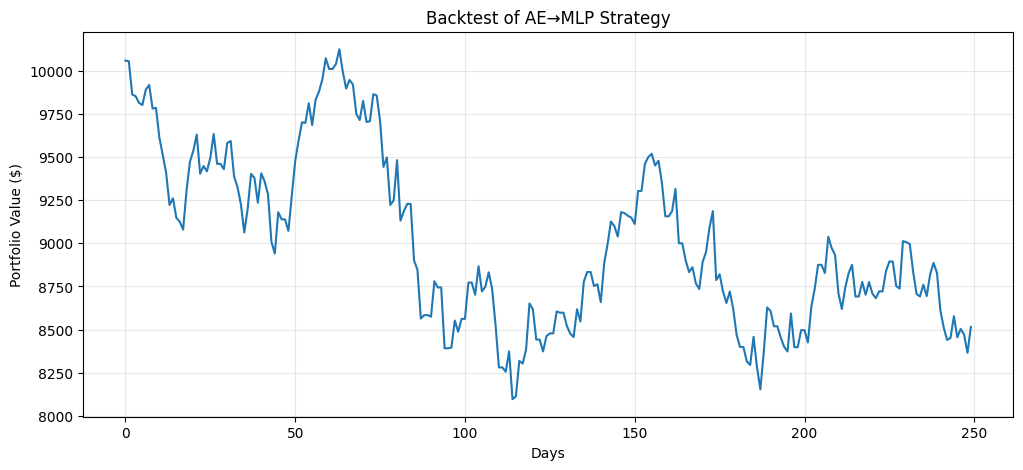

Initial capital: $10000 | Final capital: $8515.75


In [25]:
initial_capital = 10000
capital = initial_capital
positions = []

for pred, ret in zip(y_test_pred, data['Return'].values[train_size+N:]):
    if pred == 1:
        capital *= (1 + ret)  # invest in SPY
    positions.append(capital)

plt.figure(figsize=(12, 5))
plt.plot(range(len(positions)), positions)
plt.title("Backtest of AE→MLP Strategy")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Initial capital: ${initial_capital} | Final capital: ${capital:.2f}")